##Ler conjunto de dados

mostrar grafo, regularização node2vec
fazer um plot com as features, regularizada e node2vec

In [ ]:
!gdown 1OEpM2j-xwKboMcj3bj9QNT-UbYGaDfr8

Downloading...
From: https://drive.google.com/uc?id=1OEpM2j-xwKboMcj3bj9QNT-UbYGaDfr8
To: /content/dataset_filtered_normalizado.parquet
100% 7.38M/7.38M [00:00<00:00, 106MB/s]


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

graph_filtered = pd.read_parquet("dataset_filtered_normalizado.parquet")
graph_filtered.reset_index(drop=True, inplace=True)
df = graph_filtered[['artist','song','lyrics','BERT','art_representation','relationships', 'popularity']]
df.tail()

,artist,song,lyrics,BERT,art_representation,relationships,popularity
1612,Marshmello,One Thing Right,I've cheated and I've lied I've broke down and...,"[-0.6953705, -0.4586358, -0.3211222, 0.2309926...","[0.24831018880260958, 0.5703309692671396, 0.79...","[Martin Garrix, Alan Walker, Marshmello, Calvi...",73
1613,Sam Smith,How Do You Sleep?,I'm done hating myself for feeling I'm done cr...,"[-0.5536137, -0.098000206, -0.20110187, -0.027...","[0.2288964450647454, 0.5097939885173927, 0.511...","[Disclosure, AlunaGeorge, Sam Smith, Lorde]",73
1614,Jonas Brothers,Sucker,"We go together Better than birds of a feather,...","[-0.23101838, 0.0303722, -0.41449374, 0.241546...","[0.1797307079514082, 0.7553191489361701, 0.712...","[Nick Jonas, Demi Lovato, Selena Gomez, Miley ...",79
1615,Taylor Swift,Cruel Summer,"(Yeah, yeah, yeah, yeah) Fever dream high in ...","[-0.1461733, 0.053768538, -0.114705905, 0.2759...","[0.29772111244631494, 0.5940455082742316, 0.68...","[Miley Cyrus, Katy Perry, Demi Lovato, Lady A,...",78
1616,Sam Smith,Dancing With A Stranger (with Normani),I don't want to be alone tonight It's pretty c...,"[-0.15116344, -0.028514447, -0.16486284, 0.258...","[0.2288964450647454, 0.5097939885173927, 0.511...","[Disclosure, AlunaGeorge, Sam Smith, Lorde]",75


In [ ]:
df.iloc[0].BERT.shape

(768,)

In [ ]:
df.iloc[0].art_representation

array([0.2839996 , 0.68470822, 0.73335786, 0.54066986, 0.74160386,
       0.47368421, 0.08928707, 0.24009991, 0.00149822, 0.15612242,
       0.6865975 , 0.35672487])

##Construção do Grafo

#####Definição dos vértices

In [ ]:
import networkx as nx

def fix_artist_name(artist):
  return f'{artist.replace(" ","")}:artista'

#Gera o grafo a partir do df
G = nx.Graph()

for index, row in df.iterrows():

  #ATRIBUINDO NOME/ID PARA OS NÓS
  artista = fix_artist_name(row["artist"])

  node_musica = f"{index}:musica"
  node_letra = f"{index}:letra"
  node_artista = artista

  #RELACIONAMENTO ENTRE MÚSICA E LETRA, MÚSICA E ARTISTA
  G.add_edge(node_musica,node_letra)
  G.add_edge(node_musica,node_artista)

  #ADICIONANDO CARACTERÍSTICAS NOS NÓS
  G.nodes[node_musica]['art_feature'] = row["art_representation"]
  G.nodes[node_musica]['lyrics_feature'] = row["BERT"]
  G.nodes[node_musica]['type'] = 0
  G.nodes[node_musica]['label'] = row["popularity"]

  G.nodes[node_artista]['art_feature'] = row["art_representation"]
  G.nodes[node_artista]['type'] = 1

  G.nodes[node_letra]['lyrics_feature'] = row["BERT"]
  G.nodes[node_letra]['type'] = 2


In [ ]:
len(G.nodes)

3830

In [ ]:
from plotly import graph_objs as go

def show_graph(G):
  ### ARESTAS
  edge_x = []
  edge_y = []

  # adicionando as coordenadas
  for edge in G.edges():
      x0, y0 = G.nodes[edge[0]]['pos']
      x1, y1 = G.nodes[edge[1]]['pos']
      edge_x.append(x0)
      edge_x.append(x1)
      edge_x.append(None)
      edge_y.append(y0)
      edge_y.append(y1)
      edge_y.append(None)

  # definindo cor e estilo das arestas
  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=2, color='#888'),
      hoverinfo='none',
      mode='lines')

  ### VÉRTICES
  node_x = []
  node_y = []

  # adicionando as coordenadas
  for node in G.nodes():
      x, y = G.nodes[node]['pos']
      node_x.append(x)
      node_y.append(y)

  # definindo cor e estilo dos vértices
  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers',
      hoverinfo='text',
      marker=dict(
          size=10,
          line_width=2))


  node_labels = []
  for node in G.nodes():
    node_labels.append(G.nodes[node]['type'])

  node_trace.marker.color = node_labels

  # visualizando!
  fig = go.Figure(data=[edge_trace, node_trace],
              layout=go.Layout(
                  showlegend=False,
                  hovermode='closest',
                  margin=dict(b=20,l=5,r=5,t=40),
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.show()

pos = nx.spring_layout(G,seed=42) # obtém coordenadas dos vértices para visualização
for node in G.nodes():
  G.nodes[node]['pos'] = pos[node]

show_graph(G)

In [ ]:
# print a quantidade de componentes que o grafo possui
# o ideal é termos apenas 1, indicando que o grafo é conexo
len(list(nx.connected_components(G)))

596

###Construção dos relacionamentos entre artistas
- relacionamentos baseados em dados de fontes externas

In [ ]:
unique_artistas = df.artist.unique()

for artista in unique_artistas:
  df_tmp = df[df.artist==artista].head(1)
  for artista_relacionado in list(df_tmp.relationships.values[0]):
    if artista_relacionado in unique_artistas:
      G.add_edge(fix_artist_name(artista), fix_artist_name(artista_relacionado))

In [ ]:
# print a quantidade de componentes que o grafo possui
# o ideal é termos apenas 1, indicando que o grafo é conexo
len(list(nx.connected_components(G)))

3

In [ ]:
pos = nx.spring_layout(G,seed=42) # obtém coordenadas dos vértices para visualização
for node in G.nodes():
  G.nodes[node]['pos'] = pos[node]
show_graph(G)

###Construção de relacionamentos entre letras
- relacionamentos baseados em clusters

In [ ]:
from sklearn.cluster import KMeans

def get_kmeans_cluster(df, feature, k=3):
  kmeans = KMeans(n_clusters=k, random_state=42, init='random').fit(df[feature].to_list())
  df[f'{feature}_cluster'] = kmeans.labels_
  return df

df = get_kmeans_cluster(df, feature="BERT", k=3)
df.tail(5)

,artist,song,lyrics,BERT,art_representation,relationships,popularity,BERT_cluster
1612,Marshmello,One Thing Right,I've cheated and I've lied I've broke down and...,"[-0.6953705, -0.4586358, -0.3211222, 0.2309926...","[0.24831018880260958, 0.5703309692671396, 0.79...","[Martin Garrix, Alan Walker, Marshmello, Calvi...",73,1
1613,Sam Smith,How Do You Sleep?,I'm done hating myself for feeling I'm done cr...,"[-0.5536137, -0.098000206, -0.20110187, -0.027...","[0.2288964450647454, 0.5097939885173927, 0.511...","[Disclosure, AlunaGeorge, Sam Smith, Lorde]",73,2
1614,Jonas Brothers,Sucker,"We go together Better than birds of a feather,...","[-0.23101838, 0.0303722, -0.41449374, 0.241546...","[0.1797307079514082, 0.7553191489361701, 0.712...","[Nick Jonas, Demi Lovato, Selena Gomez, Miley ...",79,1
1615,Taylor Swift,Cruel Summer,"(Yeah, yeah, yeah, yeah) Fever dream high in ...","[-0.1461733, 0.053768538, -0.114705905, 0.2759...","[0.29772111244631494, 0.5940455082742316, 0.68...","[Miley Cyrus, Katy Perry, Demi Lovato, Lady A,...",78,2
1616,Sam Smith,Dancing With A Stranger (with Normani),I don't want to be alone tonight It's pretty c...,"[-0.15116344, -0.028514447, -0.16486284, 0.258...","[0.2288964450647454, 0.5097939885173927, 0.511...","[Disclosure, AlunaGeorge, Sam Smith, Lorde]",75,1


In [ ]:
unique_clusters = df['BERT_cluster'].unique()

for cluster in unique_clusters:
  df_tmp = df[df.BERT_cluster==cluster]

  indexes = list(df_tmp.index)

  for i, origem_letra in enumerate(indexes):
    for destino_letra in indexes[i:]:
      G.add_edge(f"{origem_letra}:letra", f"{destino_letra}:letra")


In [ ]:
# print a quantidade de componentes que o grafo possui
# o ideal é termos apenas 1, indicando que o grafo é conexo
len(list(nx.connected_components(G)))

1

##Regularização do grafo

In [ ]:
import networkx as nx
import numpy as np
import random

from tqdm.notebook import tqdm

# parâmetros:
# G: grafo: networkx
# dim: dimensão da embeddings/feature: int
# embedding_feature: nome da feature: str
# iterations: quantidade de iterações: int
def regularization(G, dim, embedding_feature: str = 'embedding', iterations=3, u=1.0):

  nodes = []

  # inicializando vetor f para todos os nodes
  for node in G.nodes():
      G.nodes[node]['f'] = np.array([0.0]*dim)
      if embedding_feature in G.nodes[node]:
        G.nodes[node]['f'] = np.array(G.nodes[node][embedding_feature]) * u
      nodes.append(node)

  pbar = tqdm(range(0, iterations))

  for iteration in pbar:
      random.shuffle(nodes)

      # percorrendo cada node
      for node in nodes:
          f_new = np.array([0.0]*dim)
          f_old = np.array(G.nodes[node]['f']) * u
          sum_w = 0.0

          # percorrendo vizinhos do node
          w = 1
          for neighbor in G.neighbors(node):

              f_new += G.nodes[neighbor]['f']

              sum_w += w

          f_new /= sum_w

          G.nodes[node]['f'] = f_new * u

          if embedding_feature in G.nodes[node]:
              G.nodes[node]['f'] = np.array(G.nodes[node][embedding_feature])

          G.nodes[node]['f_'+embedding_feature] = G.nodes[node]['f']

      iteration += 1
      message = 'Iteration '+str(iteration)
      pbar.set_description(message)

  return G

In [ ]:
# a regularização deve ser feito para cada tipo de feature
regularization(G, 768, 'lyrics_feature', iterations=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
regularization(G, 12, 'art_feature', iterations=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# após a regularização de todas as features, nós vamos concatenar todas elas em um vetor único
for node in G.nodes:
  G.nodes[node]["embedding_final"] = G.nodes[node]["f_lyrics_feature"].tolist() + G.nodes[node]["f_art_feature"].tolist()

##Salvar grafo

In [ ]:
# salvar grafo
import pickle
with open('grafo.gpickle', 'wb') as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ler grafo
with open(f'grafo.gpickle', 'rb') as f:
    graph = pickle.load(f)

##Plot das características inicias

<Axes: xlabel='x', ylabel='y'>

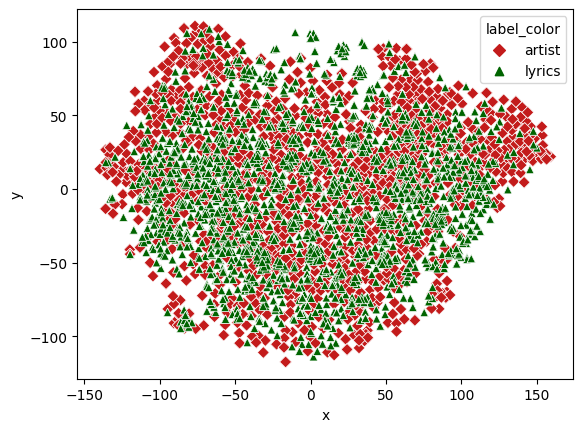

In [ ]:
df_regularized = pd.DataFrame()
art_representation = [G.nodes[node]["art_feature"] for node in G.nodes if "art_feature" in G.nodes[node]]
BERT = [G.nodes[node]["lyrics_feature"] for node in G.nodes if "lyrics_feature" in G.nodes[node]]

df_regularized["nodes"] = art_representation+BERT
df_regularized["label_color"] = (len(art_representation)*["artist"]) + (len(BERT)*["lyrics"])

import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

def get_plot_df2(df):

  artist = np.array(df[df.label_color=='artist'].nodes.tolist())
  lyrics = np.array(df[df.label_color=='lyrics'].nodes.tolist())

  lyrics_embedded = TSNE(n_components=2).fit_transform(lyrics)
  artist_embedded = TSNE(n_components=2).fit_transform(artist)

  x = np.append(lyrics_embedded[:, 0], artist_embedded[:, 0])
  y = np.append(lyrics_embedded[:, 1], artist_embedded[:, 1])

  df_plot = pd.DataFrame()
  df_plot["x"] = x
  df_plot["y"] = y

  df_plot["label_color"] = df["label_color"].tolist()

  return df_plot


df_plot = get_plot_df2(df_regularized)
markers = {"artist": "D", "lyrics":"^"}
paleta_cores = {"artist": "#C31B1B", "lyrics": "#006400"}
sns.scatterplot(data=df_plot, x="x", y="y", hue="label_color", palette=paleta_cores, style="label_color", markers=markers)

##Plot das características regularizadas

<Axes: xlabel='x', ylabel='y'>

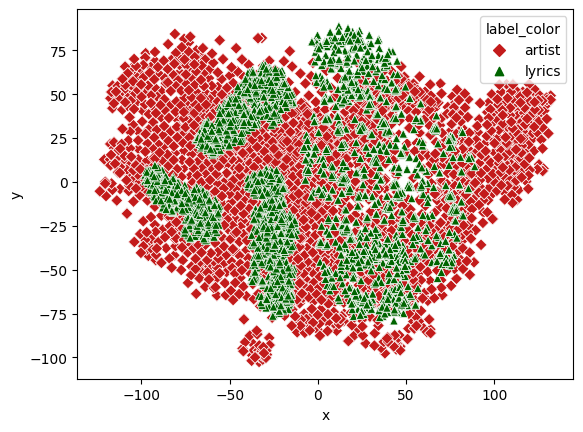

In [ ]:
df_regularized = pd.DataFrame()
art_representation = [G.nodes[node]["f_art_feature"] for node in G.nodes if "f_art_feature" in G.nodes[node]]
BERT = [G.nodes[node]["f_lyrics_feature"] for node in G.nodes if "f_lyrics_feature" in G.nodes[node]]

df_regularized["nodes"] = art_representation+BERT
df_regularized["label_color"] = (len(art_representation)*["artist"]) + (len(BERT)*["lyrics"])


df_plot = get_plot_df2(df_regularized)
markers = {"artist": "D", "lyrics":"^"}
paleta_cores = {"artist": "#C31B1B", "lyrics": "#006400"}
sns.scatterplot(data=df_plot, x="x", y="y", hue="label_color", palette=paleta_cores, style="label_color", markers=markers)

##Representação baseada em caminhada

In [ ]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


###Construção do Grafo (vértices sem características)

In [ ]:
import networkx as nx

G2 = nx.Graph()

#CRIAR OS NÓS
for index, row in df.iterrows():

  artista = fix_artist_name(row["artist"])

  node_musica = f"{index}:musica"
  node_letra = f"{index}:letra"
  node_artista = f"{artista}"

  G2.add_edge(node_musica,node_letra)
  G2.add_edge(node_musica,node_artista)

#RELACIONAMENTO ENTRE ARTISTAS
unique_artistas = df.artist.unique()

for artista in unique_artistas:
  df_tmp = df[df.artist==artista].head(1)
  for artista_relacionado in list(df_tmp.relationships.values[0]):
    if artista_relacionado in unique_artistas:
      G2.add_edge(fix_artist_name(artista), fix_artist_name(artista_relacionado))

#RELACIONAMENTO ENTRE LETRAS
unique_clusters = df['BERT_cluster'].unique()

for cluster in unique_clusters:
  df_tmp = df[df.BERT_cluster==cluster]

  indexes = list(df_tmp.index)

  for i, origem_letra in enumerate(indexes):
    for destino_letra in indexes[i:]:
      G2.add_edge(f"{origem_letra}:letra", f"{destino_letra}:letra")

###Construção das embeddings

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd

from node2vec import Node2Vec

def embed_node2vec(nx_G: nx.Graph, dimensions=5, walk_length=2, num_walks=2) -> np.array:

    #generate object
    node2vec = Node2Vec(nx_G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=1)

    #generate embeddings
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    node2vec_df = (pd.DataFrame([model.wv.get_vector(str(n)) for n in nx_G.nodes()], index = nx_G.nodes))

    node2vec_embeddings = node2vec_df.to_dict(orient='split')
    node2vec_embeddings = np.array(node2vec_embeddings["data"])
    return node2vec_embeddings


In [ ]:
df_embeddings = embed_node2vec(G2)
df_embeddings

Computing transition probabilities:   0%|          | 0/3830 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


array([[-0.10162797,  0.05516239, -0.10563277,  0.02321813, -0.03802599],
       [ 0.04026288,  0.11310188,  0.15017895,  0.18375111,  0.1385666 ],
       [-0.09481379,  0.09501065, -0.13226636, -0.07536085,  0.19309768],
       ...,
       [-0.12992129, -0.14866772, -0.00669161,  0.10259236, -0.00082941],
       [-0.11845001,  0.19222736,  0.01921974, -0.03683066, -0.07035799],
       [ 0.1257409 , -0.0839819 ,  0.04828077,  0.10159395,  0.04887329]])

In [ ]:
df_embeddings.shape

(3830, 5)

In [ ]:
node_type = [n.split(":")[-1] for n in G2.nodes()]
node_type[:10]

['musica',
 'letra',
 'artista',
 'musica',
 'letra',
 'artista',
 'musica',
 'letra',
 'artista',
 'musica']

In [ ]:
import seaborn as sns
from sklearn.manifold import TSNE

node2vec_embbed = TSNE(n_components=2).fit_transform(df_embeddings)
node2vec_embbed

array([[-13.890471 ,  37.814533 ],
       [-17.784914 , -55.20516  ],
       [-50.058094 ,  -1.8975847],
       ...,
       [ -2.251943 ,  -2.5026593],
       [ 15.379828 ,  -4.2010527],
       [ 27.761702 , -50.869877 ]], dtype=float32)

<Axes: xlabel='x', ylabel='y'>

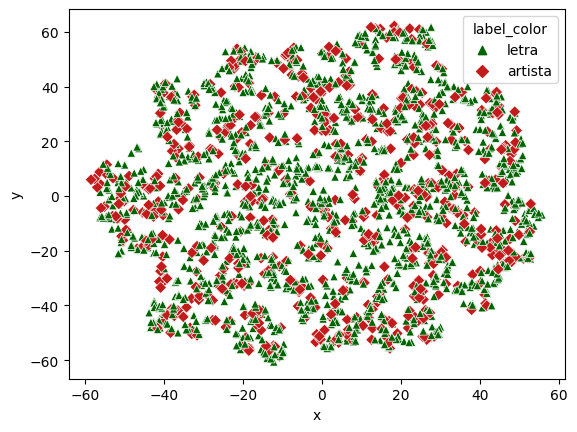

In [ ]:
node2vec_embbed_df = pd.DataFrame()

x = node2vec_embbed[:, 0]
y = node2vec_embbed[:, 1]

node2vec_embbed_df["x"] = x
node2vec_embbed_df["y"] = y

node2vec_embbed_df["label_color"] = node_type

node2vec_embbed_df = node2vec_embbed_df[node2vec_embbed_df.label_color!="musica"]

markers = {"artista": "D", "letra":"^"}
paleta_cores = {"artista": "#C31B1B", "letra": "#006400"}
sns.scatterplot(data=node2vec_embbed_df, x="x", y="y", hue="label_color", palette=paleta_cores, style="label_color", markers=markers)
